# Imports

In [1]:
import sys
sys.path.append("/home/zhhu/workspaces/deepinv/")

In [2]:
from datetime import datetime
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scienceplots
import seaborn as sns
import torch
from tqdm import tqdm, trange

import deepinv as dinv
from deepinv.models import DRUNet
from deepinv.optim.data_fidelity import L2
from deepinv.optim.prior import PnP
from deepinv.optim.optimizers import optim_builder
from deepinv.utils.demo import load_url_image, get_image_url
from deepinv.utils.plotting import plot, plot_curves
from deepinv.optim.phase_retrieval import correct_global_phase, cosine_similarity, spectral_methods, default_preprocessing, plot_error_bars, spectral_methods_wrapper
from deepinv.models.complex import to_complex_denoiser

In [3]:
import matplotlib.font_manager as fm

# Replace with the actual path from fc-list output
font_path = "/usr/share/fonts/truetype/msttcorefonts/Times_New_Roman.ttf"
fm.fontManager.addfont(font_path)

In [4]:
device = dinv.utils.get_freer_gpu() if torch.cuda.is_available() else "cpu"
device

Selected GPU 0 with 32491 MB free memory 


device(type='cuda', index=0)

In [5]:
def clean_df(df_list, start=1.8,):
    for df in df_list:
        rows_to_drop = []
        left = start
        for index, row in df.iterrows():
            if row["oversampling_ratio"] - left < 0.2:
                rows_to_drop.append(index)
            else:
                left = row["oversampling_ratio"]
        df.drop(rows_to_drop, inplace=True) 

# Investigation on Diagonal Distributions

In [7]:
df_gaussian = pd.read_csv("/home/zhhu/workspaces/deepinv/experimental/paper/runs/20240920-145834/res_structured_gaussian_0.0009765625-9.0_spectral_2_50repeat_5000iter.csv")
df_uniform_phase = pd.read_csv("/home/zhhu/workspaces/deepinv/experimental/paper/runs/20240920-102259/res_structured_uniform_phase_1.9775390625-4.9228515625_spectral_2_50repeat_5000iter.csv")
df_random_spec = pd.read_csv("/home/zhhu/workspaces/deepinv/experimental/paper/data/accuracy/res_random_spectral_100repeat_5000iter_0.10000000149011612-9.0.csv")
df_dct_uniform = pd.read_csv("/home/zhhu/workspaces/deepinv/experimental/paper/runs/20240927-141544/res_structured_dct_0.0010000000474974513-9.0_spec_50repeat.csv")
df_dct_gaussian = pd.read_csv("/home/zhhu/workspaces/deepinv/experimental/paper/runs/20240928-114545/res_structured_dct_gaussian_0.0010000000474974513-9.0_spec_50repeat.csv")
df_randimg_fdf = pd.read_csv("/home/zhhu/workspaces/deepinv/experimental/paper/runs/20240929-175332/res_structured_randimg_fdf_0.0010000000474974513-9.0_spec_50repeat.csv")
df_randimg_fdfd = pd.read_csv("/home/zhhu/workspaces/deepinv/experimental/paper/runs/20240929-175208/res_structured_randimg_fdfd_0.0010000000474974513-9.0_spec_50repeat.csv")
df_fdf_02noise = pd.read_csv("/home/zhhu/workspaces/deepinv/experimental/paper/runs/20240930-104437/res_structured_randimg_fdf_02noise_0.0010000000474974513-9.0_spec_50repeat.csv")
df_fdf_04noise = pd.read_csv("/home/zhhu/workspaces/deepinv/experimental/paper/runs/20240930-104518/res_structured_randimg_fdf_04noise_0.0010000000474974513-9.0_spec_50repeat.csv")
df_fdf_06noise = pd.read_csv("/home/zhhu/workspaces/deepinv/experimental/paper/runs/20240930-104601/res_structured_randimg_fdf_06noise_0.0010000000474974513-9.0_spec_50repeat.csv")
df_fdf_08noise = pd.read_csv("/home/zhhu/workspaces/deepinv/experimental/paper/runs/20240930-104637/res_structured_randimg_fdf_08noise_0.0010000000474974513-9.0_spec_50repeat.csv")
df_laplace = pd.read_csv("/home/zhhu/workspaces/deepinv/experimental/paper/runs/20241003-133947/res_structured_FDFD_laplace_0.0010000000474974513-9.0_spec_50repeat.csv")
df_student_t_df5 = pd.read_csv("/home/zhhu/workspaces/deepinv/experimental/paper/runs/20241003-134024/res_structured_FDFD_student-t_df=5_0.0010000000474974513-9.0_spec_50repeat.csv")
df_student_t_df50 = pd.read_csv("/home/zhhu/workspaces/deepinv/experimental/paper/runs/20241003-134050/res_structured_FDFD_student-t_df=50_0.0010000000474974513-9.0_spec_50repeat.csv")
df_student_t_df500 = pd.read_csv("/home/zhhu/workspaces/deepinv/experimental/paper/runs/20241003-134121/res_structured_FDFD_student-t_df=500_0.0010000000474974513-9.0_spec_50repeat.csv")
df_student_t_df10 = pd.read_csv("/home/zhhu/workspaces/deepinv/experimental/paper/runs/20241004-120412/res_structured_FDFD_student-t_df=10_0.0010000000474974513-9.0_spec_50repeat.csv")
df_student_t_df15 = pd.read_csv("/home/zhhu/workspaces/deepinv/experimental/paper/runs/20241004-120501/res_structured_FDFD_student-t_df=15_0.0010000000474974513-9.0_spec_50repeat.csv")
df_student_t_df20 = pd.read_csv("/home/zhhu/workspaces/deepinv/experimental/paper/runs/20241004-120534/res_structured_FDFD_student-t_df=20_0.0010000000474974513-9.0_spec_50repeat.csv")
df_student_t_df30 = pd.read_csv("/home/zhhu/workspaces/deepinv/experimental/paper/runs/20241004-120552/res_structured_FDFD_student-t_df=30_0.0010000000474974513-9.0_spec_50repeat.csv")

In [8]:
# try different images
df_shepplogan_fdf = pd.read_csv("/home/zhhu/workspaces/deepinv/experimental/paper/runs/20241014-123605/res_structured_FDF_shepp-logan_shepp-logan_spec_0.0010000000474974513-9.0_50repeat.csv")
df_random_fdf = pd.read_csv("/home/zhhu/workspaces/deepinv/experimental/paper/runs/20241014-123951/res_structured_FDF_random_spec_0.0010000000474974513-9.0_50repeat.csv")
df_delta_fdf = pd.read_csv("/home/zhhu/workspaces/deepinv/experimental/paper/runs/20241014-124113/res_structured_FDF_delta_spec_0.0010000000474974513-9.0_50repeat.csv")
df_reverse_shepplogan_fdf = pd.read_csv("/home/zhhu/workspaces/deepinv/experimental/paper/runs/20241015-140719/res_structured_shepplogan_reverse_shepp-logan_spec_0.0010000000474974513-9.0_50repeat.csv")
df_shepplogan_vary3_fdf = pd.read_csv("/home/zhhu/workspaces/deepinv/experimental/paper/runs/20241014-124214/res_structured_FDF_shepp-logan_spec_0.0010000000474974513-9.0_50repeat.csv")
df_shepplogan_vary5_fdf = pd.read_csv("/home/zhhu/workspaces/deepinv/experimental/paper/runs/20241015-114418/res_structured_FDF_shepp-logan_spec_0.0010000000474974513-9.0_50repeat.csv")
df_shepplogan_vary10_fdf = pd.read_csv("/home/zhhu/workspaces/deepinv/experimental/paper/runs/20241015-114509/res_structured_FDF_shepp-logan_spec_0.0010000000474974513-9.0_50repeat.csv")
df_shepplogan_vary20_fdf = pd.read_csv("/home/zhhu/workspaces/deepinv/experimental/paper/runs/20241015-114527/res_structured_FDF_shepp-logan_spec_0.0010000000474974513-9.0_50repeat.csv")
df_shepplogan_vary40_fdf = pd.read_csv("/home/zhhu/workspaces/deepinv/experimental/paper/runs/20241015-114541/res_structured_FDF_shepp-logan_spec_0.0010000000474974513-9.0_50repeat.csv")

In [9]:
df_full_spec = pd.read_csv("/home/zhhu/workspaces/deepinv/experimental/paper/data/accuracy/res_random_spectral_100repeat_5000iter_0.10000000149011612-9.0.csv")
df_marchenko_FD_spec = pd.read_csv("/home/zhhu/workspaces/deepinv/experimental/paper/runs/20241016-112516/res_structured_marchenko-pastur-FD_shepp-logan_spec_1.0635000467300415-9.0_50repeat.csv")
df_uniform_mag_FD_spec = pd.read_csv("/home/zhhu/workspaces/deepinv/experimental/paper/runs/20241016-125620/res_structured_uniform_magnitude_FD_shepp-logan_spec_0.0010000000474974513-9.0_50repeat.csv")

In [14]:
df_shepp_permute1 = pd.read_csv("/home/zhhu/workspaces/deepinv/experimental/paper/runs/20241016-165053/res_structured_permuted_shepp_FDF_shepp-logan_spec_0.0010000000474974513-9.0_50repeat.csv")
df_shepp_permute2 = pd.read_csv("/home/zhhu/workspaces/deepinv/experimental/paper/runs/20241016-165102/res_structured_permuted_shepp_FDF_shepp-logan_spec_0.0010000000474974513-9.0_50repeat.csv")
df_shepp_permute3 = pd.read_csv("/home/zhhu/workspaces/deepinv/experimental/paper/runs/20241016-165102/res_structured_permuted_shepp_FDF_shepp-logan_spec_0.0010000000474974513-9.0_50repeat.csv")
df_shepp_F = pd.read_csv("/home/zhhu/workspaces/deepinv/experimental/paper/runs/20241017-130635/res_structured_shepp_F_shepp-logan_spec_0.8213000297546387-9.0_50repeat.csv")

In [15]:
clean_df([df_gaussian, df_uniform_phase, df_random_spec, df_dct_uniform, df_dct_gaussian, df_randimg_fdf, df_randimg_fdfd, df_fdf_02noise, df_fdf_04noise, df_fdf_06noise, df_fdf_08noise, df_laplace, df_student_t_df5, df_student_t_df50, df_student_t_df500, df_student_t_df10, df_student_t_df15, df_student_t_df20, df_student_t_df30], start=0.0)

clean_df([df_shepplogan_fdf, df_random_fdf, df_delta_fdf, df_shepplogan_vary3_fdf, df_shepplogan_vary5_fdf, df_shepplogan_vary10_fdf, df_shepplogan_vary20_fdf, df_shepplogan_vary40_fdf, df_reverse_shepplogan_fdf, df_full_spec, df_marchenko_FD_spec, df_uniform_mag_FD_spec, df_shepp_permute1, df_shepp_permute2, df_shepp_permute3, df_shepp_F], start=0.0)

shepplogan
(0.12156862745098039, 0.4666666666666667, 0.7058823529411765) shepplogan
permute1
(1.0, 0.4980392156862745, 0.054901960784313725) permute1
permute2
(0.17254901960784313, 0.6274509803921569, 0.17254901960784313) permute2
permute3
(0.8392156862745098, 0.15294117647058825, 0.1568627450980392) permute3


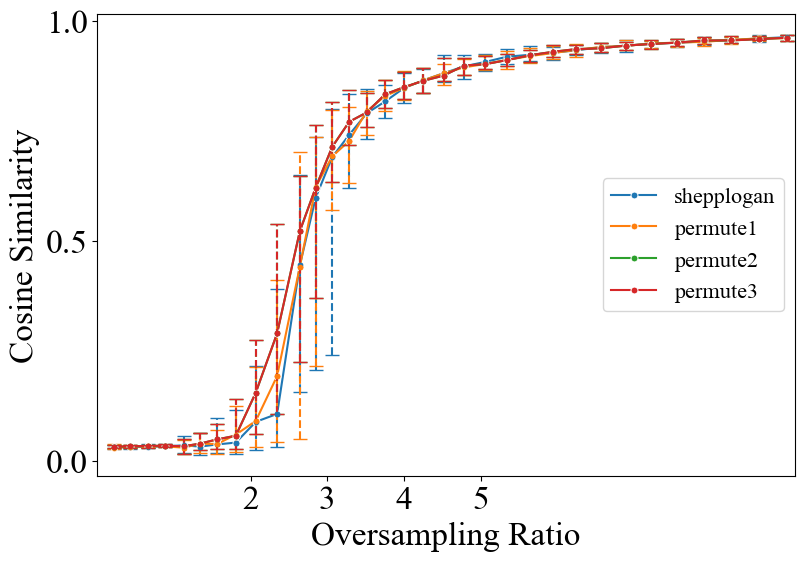

In [11]:
# same entropy
plot_error_bars(
    [
        df_shepplogan_fdf["oversampling_ratio"],
        df_shepp_permute1["oversampling_ratio"],
        df_shepp_permute2["oversampling_ratio"],
        df_shepp_permute3["oversampling_ratio"],
    ],
    [
        df_shepplogan_fdf,
        df_shepp_permute1,
        df_shepp_permute2,
        df_shepp_permute3,
    ],
    [
        "shepplogan",
        "permute1",
        "permute2",
        "permute3",
    ],
    #title="Performance Comparison of Different Number of Layers",
    #save="layers_gd_spec.svg",
    figsize=(9,6),
    plot="n_layers",
    xlim=(0.0,9.1),
    xticks=[2,3,4,5],
    yticks=[0.0,0.5,1.0],
    legend_loc="center right",
    labelsize=24,
    fontsize=16,
    #save_dir='paper/figures/layers.pdf',
    ticksize=24,
    transparent=True
)

Random
(0.12156862745098039, 0.4666666666666667, 0.7058823529411765) Random
Marchenko-Pastur FD
(1.0, 0.4980392156862745, 0.054901960784313725) Marchenko-Pastur FD
Uniform Magnitude FD
(0.17254901960784313, 0.6274509803921569, 0.17254901960784313) Uniform Magnitude FD
F
(0.8392156862745098, 0.15294117647058825, 0.1568627450980392) F


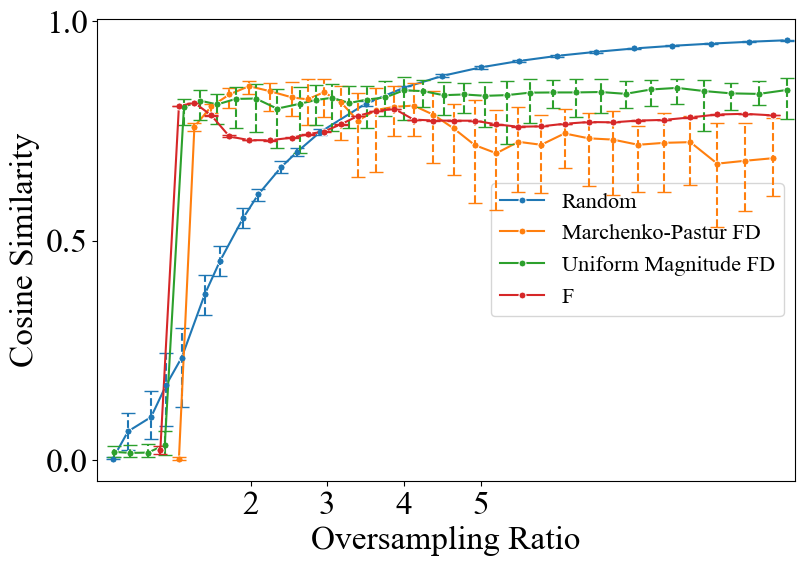

In [18]:
# real diagonal
# try different signals
plot_error_bars(
    [
        df_full_spec["oversampling_ratio"],
        df_marchenko_FD_spec["oversampling_ratio"],
        df_uniform_mag_FD_spec["oversampling_ratio"],
        df_shepp_F["oversampling_ratio"],
    ],
    [
        df_full_spec,
        df_marchenko_FD_spec,
        df_uniform_mag_FD_spec,
        df_shepp_F,
    ],
    [
        "Random",
        "Marchenko-Pastur FD",
        "Uniform Magnitude FD",
        'F',
    ],
    #title="Performance Comparison of Different Number of Layers",
    #save="layers_gd_spec.svg",
    figsize=(9,6),
    plot="n_layers",
    xlim=(0.0,9.1),
    xticks=[2,3,4,5],
    yticks=[0.0,0.5,1.0],
    legend_loc="center right",
    labelsize=24,
    fontsize=16,
    #save_dir='paper/figures/layers.pdf',
    ticksize=24,
    transparent=True
)

Shepp-Logan
(0.12156862745098039, 0.4666666666666667, 0.7058823529411765) Shepp-Logan
Random
(1.0, 0.4980392156862745, 0.054901960784313725) Random
Delta
(0.17254901960784313, 0.6274509803921569, 0.17254901960784313) Delta
Shepp-Logan varying max 3
(0.8392156862745098, 0.15294117647058825, 0.1568627450980392) Shepp-Logan varying max 3
Shepp-Logan varying max 5
(0.5803921568627451, 0.403921568627451, 0.7411764705882353) Shepp-Logan varying max 5
Shepp-Logan varying max 10
(0.5490196078431373, 0.33725490196078434, 0.29411764705882354) Shepp-Logan varying max 10
Shepp-Logan varying max 20
(0.8901960784313725, 0.4666666666666667, 0.7607843137254902) Shepp-Logan varying max 20
Shepp-Logan varying max 40
(0.4980392156862745, 0.4980392156862745, 0.4980392156862745) Shepp-Logan varying max 40
Reverse Shepp-Logan
(0.7372549019607844, 0.7411764705882353, 0.13333333333333333) Reverse Shepp-Logan


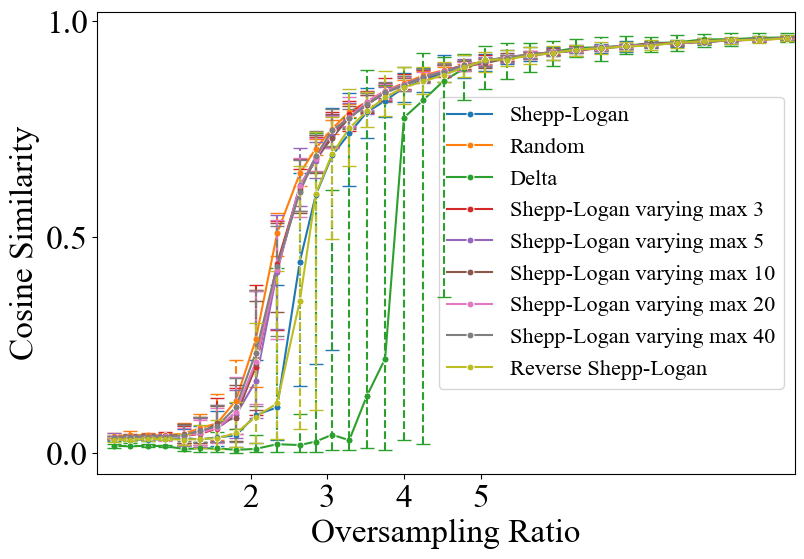

In [13]:
# different images
plot_error_bars(
    [
        df_shepplogan_fdf["oversampling_ratio"],
        df_random_fdf["oversampling_ratio"],
        df_delta_fdf["oversampling_ratio"],
        df_shepplogan_vary3_fdf["oversampling_ratio"],
        df_shepplogan_vary5_fdf["oversampling_ratio"],
        df_shepplogan_vary10_fdf["oversampling_ratio"],
        df_shepplogan_vary20_fdf["oversampling_ratio"],
        df_shepplogan_vary40_fdf["oversampling_ratio"],
        df_reverse_shepplogan_fdf["oversampling_ratio"],
    ],
    [
        df_shepplogan_fdf,
        df_random_fdf,
        df_delta_fdf,
        df_shepplogan_vary3_fdf,
        df_shepplogan_vary5_fdf,
        df_shepplogan_vary10_fdf,
        df_shepplogan_vary20_fdf,
        df_shepplogan_vary40_fdf,
        df_reverse_shepplogan_fdf
    ],
    [
        "Shepp-Logan",
        "Random",
        "Delta",
        "Shepp-Logan varying max 3",
        "Shepp-Logan varying max 5",
        "Shepp-Logan varying max 10",
        "Shepp-Logan varying max 20",
        "Shepp-Logan varying max 40",
        "Reverse Shepp-Logan",
    ],
    #title="Performance Comparison of Different Number of Layers",
    #save="layers_gd_spec.svg",
    figsize=(9,6),
    plot="n_layers",
    xlim=(0.0,9.1),
    xticks=[2,3,4,5],
    yticks=[0.0,0.5,1.0],
    legend_loc="center right",
    labelsize=24,
    fontsize=16,
    #save_dir='paper/figures/layers.pdf',
    ticksize=24,
    transparent=True
)

shepplogan fdf
(0.12156862745098039, 0.4666666666666667, 0.7058823529411765) shepplogan fdf
0.2 noise fdf
(1.0, 0.4980392156862745, 0.054901960784313725) 0.2 noise fdf
0.4 noise fdf
(0.17254901960784313, 0.6274509803921569, 0.17254901960784313) 0.4 noise fdf
0.6 noise fdf
(0.8392156862745098, 0.15294117647058825, 0.1568627450980392) 0.6 noise fdf
1.0 noise fdf
(0.5803921568627451, 0.403921568627451, 0.7411764705882353) 1.0 noise fdf
1.0 noise fdfd
(0.5490196078431373, 0.33725490196078434, 0.29411764705882354) 1.0 noise fdfd


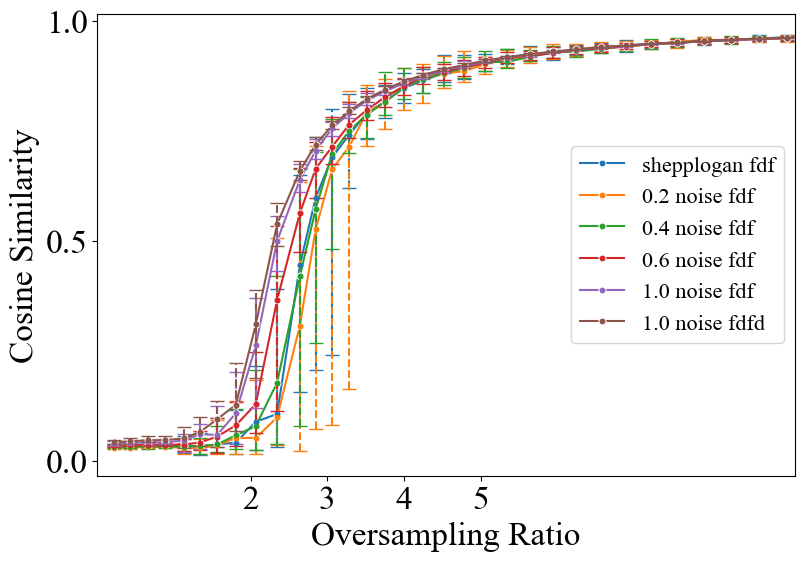

In [12]:
# different noise
plot_error_bars(
    [
        df_shepplogan_fdf["oversampling_ratio"],
        df_fdf_02noise["oversampling_ratio"],
        df_fdf_04noise["oversampling_ratio"],
        df_fdf_06noise["oversampling_ratio"],
        #df_fdf_08noise["oversampling_ratio"],
        df_randimg_fdf["oversampling_ratio"],
        df_randimg_fdfd["oversampling_ratio"],
    ],
    [
        df_shepplogan_fdf,
        df_fdf_02noise,
        df_fdf_04noise,
        df_fdf_06noise,
        #df_fdf_08noise,
        df_randimg_fdf,
        df_randimg_fdfd,
    ],
    [
        "shepplogan fdf",
        "0.2 noise fdf",
        "0.4 noise fdf",
        "0.6 noise fdf",
        #"0.8 noise fdf",
        "1.0 noise fdf",
        "1.0 noise fdfd",
    ],
    #title="Performance Comparison of Different Number of Layers",
    #save="layers_gd_spec.svg",
    figsize=(9,6),
    plot="n_layers",
    xlim=(0.0,9.1),
    xticks=[2,3,4,5],
    yticks=[0.0,0.5,1.0],
    legend_loc="center right",
    labelsize=24,
    fontsize=16,
    #save_dir='paper/figures/layers.pdf',
    ticksize=24,
    transparent=True
)

# Different Sampling Distributions

In [12]:
df_gaussian = pd.read_csv("/home/zhhu/workspaces/deepinv/experimental/paper/runs/20240920-145834/res_structured_gaussian_0.0009765625-9.0_spectral_2_50repeat_5000iter.csv")
df_gaussian_unit_fdf = pd.read_csv("/home/zhhu/workspaces/deepinv/experimental/paper/runs/20241017-155002/res_structured_shepp_gaussian_unit_mag_FDF_shepp-logan_spec_0.0010000000474974513-9.0_50repeat.csv")
df_gaussian_unit_fdfd = pd.read_csv("/home/zhhu/workspaces/deepinv/experimental/paper/runs/20241017-155136/res_structured_shepp_gaussian_unit_mag_FDFD_shepp-logan_spec_0.0010000000474974513-9.0_50repeat.csv")
df_laplace_unit_fdf = pd.read_csv("/home/zhhu/workspaces/deepinv/experimental/paper/runs/20241017-155411/res_structured_shepp_laplace_unit_mag_FDF_shepp-logan_spec_0.0010000000474974513-9.0_50repeat.csv")
df_laplace_unit_fdfd = pd.read_csv("/home/zhhu/workspaces/deepinv/experimental/paper/runs/20241017-155352/res_structured_shepp_laplace_unit_mag_FDFD_shepp-logan_spec_0.0010000000474974513-9.0_50repeat.csv")
df_uniform_phase = pd.read_csv("/home/zhhu/workspaces/deepinv/experimental/paper/runs/20240920-102259/res_structured_uniform_phase_1.9775390625-4.9228515625_spectral_2_50repeat_5000iter.csv")
df_polar_fdf = pd.read_csv("/home/zhhu/workspaces/deepinv/experimental/paper/runs/20241023-150901/res_structured_polar_FDF_shepp-logan_spec_0.0010000000474974513-9.0_50repeat.csv")
df_polar_fdfd = pd.read_csv("/home/zhhu/workspaces/deepinv/experimental/paper/runs/20241023-150933/res_structured_polar_FDFD_shepp-logan_spec_0.0010000000474974513-9.0_50repeat.csv")

In [13]:
clean_df([df_gaussian, df_gaussian_unit_fdf, df_gaussian_unit_fdfd, df_laplace_unit_fdf, df_laplace_unit_fdfd, df_uniform_phase, df_polar_fdf, df_polar_fdfd], start=0.0)

uniform phase fdfd
(0.12156862745098039, 0.4666666666666667, 0.7058823529411765) uniform phase fdfd
gaussian fdfd
(1.0, 0.4980392156862745, 0.054901960784313725) gaussian fdfd
gaussian unit fdf
(0.17254901960784313, 0.6274509803921569, 0.17254901960784313) gaussian unit fdf
gaussian unit fdfd
(0.8392156862745098, 0.15294117647058825, 0.1568627450980392) gaussian unit fdfd
laplace unit fdf
(0.5803921568627451, 0.403921568627451, 0.7411764705882353) laplace unit fdf
laplace unit fdfd
(0.5490196078431373, 0.33725490196078434, 0.29411764705882354) laplace unit fdfd
polar fdf
(0.8901960784313725, 0.4666666666666667, 0.7607843137254902) polar fdf
polar fdfd
(0.4980392156862745, 0.4980392156862745, 0.4980392156862745) polar fdfd


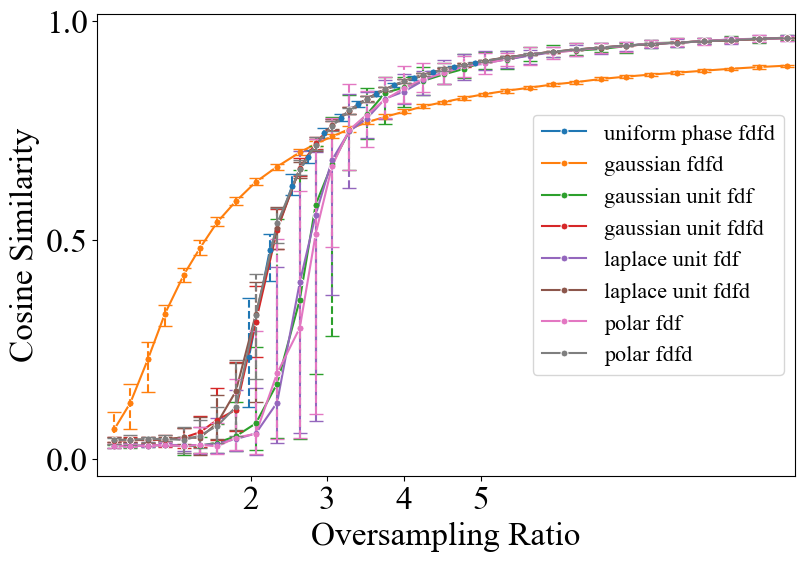

In [14]:
plot_error_bars(
    [
        df_uniform_phase["oversampling_ratio"],
        df_gaussian["oversampling_ratio"],
        df_gaussian_unit_fdf["oversampling_ratio"],
        df_gaussian_unit_fdfd["oversampling_ratio"],
        df_laplace_unit_fdf["oversampling_ratio"],
        df_laplace_unit_fdfd["oversampling_ratio"],
        df_polar_fdf["oversampling_ratio"],
        df_polar_fdfd["oversampling_ratio"],
    ],
    [
        df_uniform_phase, 
        df_gaussian,
        df_gaussian_unit_fdf,
        df_gaussian_unit_fdfd,
        df_laplace_unit_fdf,
        df_laplace_unit_fdfd,
        df_polar_fdf,
        df_polar_fdfd,
    ],
    [
        "uniform phase fdfd",
        "gaussian fdfd",
        "gaussian unit fdf",
        "gaussian unit fdfd",
        "laplace unit fdf",
        "laplace unit fdfd",
        "polar fdf",
        "polar fdfd",
    ],
    #title="Performance Comparison of Different Number of Layers",
    #save="layers_gd_spec.svg",
    figsize=(9,6),
    plot="n_layers",
    xlim=(0.0,9.1),
    xticks=[2,3,4,5],
    yticks=[0.0,0.5,1.0],
    legend_loc="center right",
    labelsize=24,
    fontsize=16,
    #save_dir='paper/figures/layers.pdf',
    ticksize=24,
    transparent=True,
)

# Structure Comparison

In [32]:
# load data
load_path = Path("/home/zhhu/workspaces/deepinv/experimental/paper/data/number_of_layers")

df_1_spec = pd.read_csv(load_path / "res_structured_1_spectral_100repeat_5000iter_2.0284664630889893-4.983266830444336.csv")
df_FDF_spec = pd.read_csv(load_path / "res_structured_1_spectral_100repeat_5000iter_1.0-4.9228515625.csv")
df_2_spec = pd.read_csv(load_path / "res_structured_2_spectral_100repeat_5000iter_2.0284664630889893-4.983266830444336.csv")
df_3_spec = pd.read_csv(load_path / "res_structured_3_spectral_100repeat_5000iter_2.0284664630889893-4.983266830444336.csv")
df_4_spec = pd.read_csv(load_path / "res_structured_4_spectral_100repeat_5000iter_2.0284664630889893-4.983266830444336.csv")
df_haar_spec = pd.read_csv(load_path / "res_random-haar_spectral_64size_100repeat_5000iter_2.0-5.0.csv")
df_unit_full = pd.read_csv("/home/zhhu/workspaces/deepinv/experimental/paper/runs/20241023-162908/res_full-unit_shepp-logan_spec_0.10000000149011612-5.0_50repeat.csv")
df_circular = pd.read_csv("/home/zhhu/workspaces/deepinv/experimental/paper/runs/20241023-162807/res_full-circular_shepp-logan_spec_0.10000000149011612-5.0_50repeat.csv")
df_gaussian = pd.read_csv("/home/zhhu/workspaces/deepinv/experimental/paper/data/accuracy/res_random_spectral_100repeat_5000iter_0.10000000149011612-9.0.csv")

# df_1_gd_spec = pd.read_csv(load_path /"res_structured_1_gd-spectral_100repeat_10000iter_2.0284664630889893-4.983266830444336.csv")
# df_FDF_gd_spec = pd.read_csv(load_path / "res_structured_1_gd-spectral_100repeat_10000iter_2.06640625-4.78515625.csv")
# df_2_gd_spec = pd.read_csv(load_path / "res_structured_2_gd-spectral_100repeat_10000iter_2.0284664630889893-4.983266830444336.csv")
# df_3_gd_spec = pd.read_csv(load_path / "res_structured_3_gd-spectral_100repeat_10000iter_2.0284664630889893-4.983266830444336.csv")
# df_4_gd_spec = pd.read_csv(load_path / "res_structured_4_gd-spectral_100repeat_10000iter_2.0284664630889893-4.983266830444336.csv")
# df_haar_gd_spec = pd.read_csv(load_path / "res_random-haar_gd_spectral_100repeat_10000iter_2.0-5.0.csv")

In [33]:
clean_df([df_1_spec,df_FDF_spec,df_2_spec,df_3_spec,df_4_spec,df_haar_spec,df_unit_full, df_circular, df_gaussian], start=0.0)

In [34]:
df_1_spec.head()

,Unnamed: 0,oversampling_ratio,repeat0,repeat1,repeat2,repeat3,repeat4,repeat5,repeat6,repeat7,...,repeat90,repeat91,repeat92,repeat93,repeat94,repeat95,repeat96,repeat97,repeat98,repeat99
0,0,2.028466,0.011578,0.028169,0.042484,0.019128,0.036256,0.037208,0.037390,0.021961,...,0.027365,0.045563,0.036923,0.034269,0.034026,0.030932,0.037097,0.035328,0.027185,0.035527
4,4,2.265177,0.031514,0.034536,0.041446,0.033679,0.044497,0.036083,0.029360,0.042056,...,0.036046,0.040957,0.030051,0.042978,0.033044,0.031706,0.037950,0.038470,0.037372,0.041064
8,8,2.514947,0.037847,0.030888,0.039150,0.027325,0.038766,0.029141,0.034737,0.028294,...,0.045136,0.019167,0.028917,0.010226,0.045441,0.037780,0.044688,0.050412,0.040064,0.037674
12,12,2.777778,0.043617,0.038693,0.037109,0.030309,0.038016,0.035241,0.040921,0.042996,...,0.036435,0.043903,0.031775,0.032249,0.045392,0.034725,0.024843,0.038905,0.036469,0.025588
15,15,2.983471,0.038176,0.043656,0.033457,0.042278,0.038881,0.036604,0.036672,0.030072,...,0.032972,0.028998,0.030769,0.028301,0.037120,0.029446,0.035273,0.044219,0.016005,0.039530


1 layer
(0.12156862745098039, 0.4666666666666667, 0.7058823529411765) 1 layer
1.5 layers
(1.0, 0.4980392156862745, 0.054901960784313725) 1.5 layers
2 layers
(0.17254901960784313, 0.6274509803921569, 0.17254901960784313) 2 layers
3 layers
(0.8392156862745098, 0.15294117647058825, 0.1568627450980392) 3 layers
4 layers
(0.5803921568627451, 0.403921568627451, 0.7411764705882353) 4 layers
haar
(0.5490196078431373, 0.33725490196078434, 0.29411764705882354) haar
gaussian
(0.8901960784313725, 0.4666666666666667, 0.7607843137254902) gaussian
unit full
(0.4980392156862745, 0.4980392156862745, 0.4980392156862745) unit full


circular
(0.7372549019607844, 0.7411764705882353, 0.13333333333333333) circular


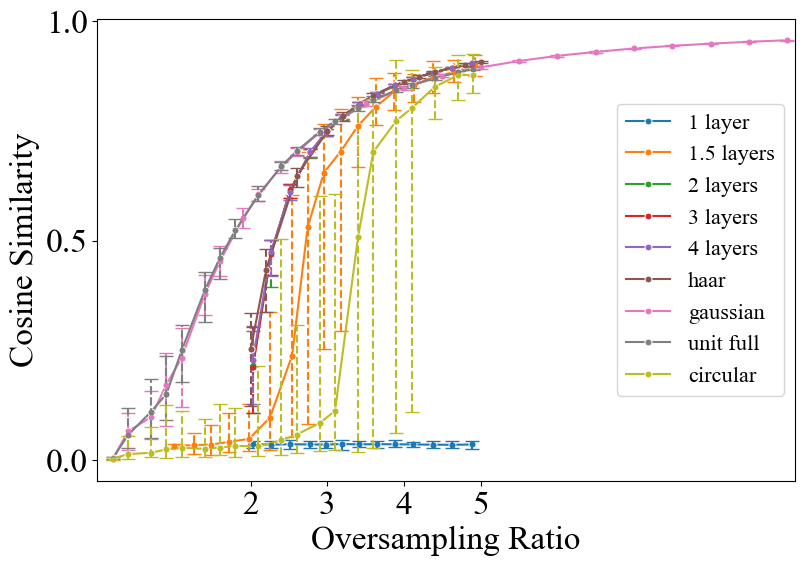

In [35]:
# plot
plot_error_bars([
    df_1_spec["oversampling_ratio"],
    df_FDF_spec["oversampling_ratio"],
    df_2_spec["oversampling_ratio"],
    df_3_spec["oversampling_ratio"],
    df_4_spec["oversampling_ratio"],
    df_haar_spec["oversampling_ratio"],
    df_gaussian["oversampling_ratio"],
    df_unit_full["oversampling_ratio"],
    df_circular["oversampling_ratio"],
    ],
    [
    df_1_spec,
    df_FDF_spec,
    df_2_spec,
    df_3_spec,
    df_4_spec,
    df_haar_spec,
    df_gaussian,
    df_unit_full,
    df_circular,
    ],
    [
    "1 layer",
    "1.5 layers",
    "2 layers",
    "3 layers",
    "4 layers",
    "haar",
    "gaussian",
    "unit full",
    "circular",
    ],
    #title="Performance Comparison of Different Number of Layers",
    #save="layers_gd_spec.svg",
    figsize=(9,6),
    plot="n_layers",
    xlim=(0.0,9.1),
    xticks=[2,3,4,5],
    yticks=[0.0,0.5,1.0],
    legend_loc="center right",
    labelsize=24,
    fontsize=16,
    #save_dir='paper/figures/layers.pdf',
    ticksize=24,
    transparent=True
)

Observation:

full model gaussian normalized/unnormalized perform the same, only rely on E and Var of cosine similarity?

circular != fdf, because of 2d fft? sensing in two dimensions?

# Visualization 

torch.Size([1, 1, 128, 128])


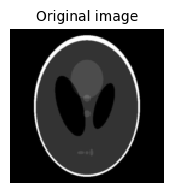

In [8]:
# generate signal
img_size = 128
url = get_image_url("SheppLogan.png")
x = load_url_image(
    url=url, img_size=img_size, grayscale=True, resize_mode="resize", device=device
)
print(x.shape)
plot(x, titles="Original image",fontsize=10)

# generate phase signal

# The phase is computed as 2*pi*x - pi, where x is the original image.
x_phase = torch.exp(1j*x*torch.pi - 0.5j*torch.pi).to(device)

# Every element of the signal should have unit norm.
assert torch.allclose(x_phase.real**2 + x_phase.imag**2, torch.tensor(1.0))

In [9]:
# create 3 models with different oversampling: 2.0, 2.5, 3.0

output_sizes = {1:180, 2:202, 3:221}
recons = [x]

for i in range(1,4):
    physics = dinv.physics.StructuredRandomPhaseRetrieval(
        n_layers=2,
        input_shape=(1, img_size, img_size),
        output_shape=(1, output_sizes[i], output_sizes[i]),
        drop_tail=True,
        shared_weights=True,
        dtype = torch.cfloat,
        device=device,
    )

    y = physics.forward(x_phase)

    params_algo = {"stepsize": 6e-3*physics.oversampling_ratio.item(), "g_params": 0.00}

    model = optim_builder(
        iteration="PGD",
        prior=dinv.optim.prior.Zero(),
        data_fidelity=dinv.optim.data_fidelity.L2(),
        early_stop=True,
        max_iter=20000,
        verbose=False,
        params_algo=params_algo,
        custom_init=spectral_methods_wrapper,
    )

    x_phase_recon = model(y, physics, x_gt=x_phase)
    x_phase_recon = correct_global_phase(x_phase_recon,x_phase)
    x_recon = torch.angle(x_phase_recon) / (2*torch.pi) + 0.5
    recons.append(x_recon)

Image 0, channel 0 does not have a global phase shift.
Power iteration early stopping at iteration 4680.
Image 0, channel 0 does not have a global phase shift.
Power iteration early stopping at iteration 1911.
Image 0, channel 0 does not have a global phase shift.


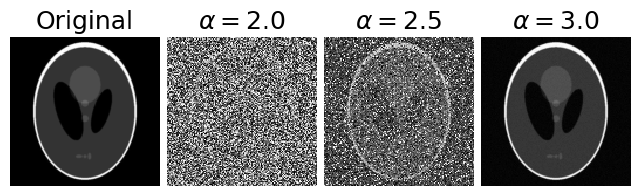

In [16]:
# visuliazation
plot(recons, figsize=(8,3), titles=["Original",r"$\alpha=2.0$", r"$\alpha=2.5$", r"$\alpha=3.0$"],save='paper/figures/recons.pdf',fontsize=18,transparent=True,)

# Reconstruction Accuracy

In [14]:
load_path = Path("/home/zhhu/workspaces/deepinv/experimental/paper/data/accuracy")

In [15]:
df_random_gd_spec = pd.read_csv(load_path/"res_random_gd_spectral_100repeat_10000iter_0.10000000149011612-9.0.csv")
df_random_gd_spec_small = pd.read_csv(load_path /"res_random_gd_spectral_100repeat_10000iter_2.0-2.5999999046325684.csv")
df_random_spec = pd.read_csv(load_path /"res_random_spectral_100repeat_5000iter_0.10000000149011612-9.0.csv")
df_random_gd_rand = pd.read_csv(load_path /"res_random_gd_random_100repeat_10000iter_0.10000000149011612-9.0.csv")
df_structured_gd_spec = pd.read_csv(load_path /"res_structured_gd_spectral_100repeat_10000iter_0.0001020304043777287-9.0.csv")
df_structured_spec = pd.read_csv(load_path /"res_structured_2_spectral_100repeat_5000iter_0.0009765625-9.0.csv")
df_structured_gd_rand = pd.read_csv(load_path /"res_structured_2_gd-rand_100repeat_10000iter_0.0009765625-9.0.csv")

In [16]:
df_structured_spec.head(n=15)
df_structured_gd_spec.dtypes

Unnamed: 0              int64
oversampling_ratio    float64
step_size              object
repeat0               float64
repeat1               float64
                       ...   
repeat95              float64
repeat96              float64
repeat97              float64
repeat98              float64
repeat99              float64
Length: 103, dtype: object

In [17]:
for oversampling_ratio in [2.0,2.1,2.2,2.3,2.4,2.5,2.6]:
    df_random_gd_spec.loc[df_random_gd_spec["oversampling_ratio"] == oversampling_ratio] = df_random_gd_spec_small.loc[df_random_gd_spec_small["oversampling_ratio"] == oversampling_ratio].values

In [18]:
1.0 % 0.2

0.19999999999999996

In [19]:
for df in [df_random_gd_spec, df_random_spec, df_random_gd_rand]:
    rows_to_drop = []
    for index, row in df.iterrows():
        if round(row['oversampling_ratio']*10) % 2 != 0 and row['oversampling_ratio']< 3.0:
            rows_to_drop.append(index)

    df.drop(rows_to_drop, inplace=True)

In [20]:
for df in [df_structured_gd_rand, df_structured_gd_spec, df_structured_spec]:
    rows_to_drop = []
    left = -0.15
    for index, row in df.iterrows():
        if row["oversampling_ratio"] - left < 0.2:
            rows_to_drop.append(index)
        else:
            left = row["oversampling_ratio"]
    df.drop(rows_to_drop, inplace=True) 

In [21]:
oversampling_ratios_random_gd_spec = df_random_gd_spec["oversampling_ratio"]
oversampling_ratios_random_spec = df_random_spec["oversampling_ratio"]
oversampling_ratios_random_gd_rand = df_random_gd_rand["oversampling_ratio"]
oversampling_ratios_structured_gd_spec = df_structured_gd_spec["oversampling_ratio"]
oversampling_ratios_structured_spec = df_structured_spec["oversampling_ratio"]
oversampling_ratios_structured_gd_rand = df_structured_gd_rand["oversampling_ratio"]

iid gd spec
(0.12156862745098039, 0.47058823529411764, 0.7058823529411765) iid gd spec
iid spec
(0.12156862745098039, 0.47058823529411764, 0.7058823529411765) iid spec
iid gd rand
(0.12156862745098039, 0.47058823529411764, 0.7058823529411765) iid gd rand
structured gd spec
(1.0, 0.4980392156862745, 0.0) structured gd spec
structured spec
(1.0, 0.4980392156862745, 0.0) structured spec
structured gd rand
(1.0, 0.4980392156862745, 0.0) structured gd rand
Figure saved to paper/figures/accuracy.pdf


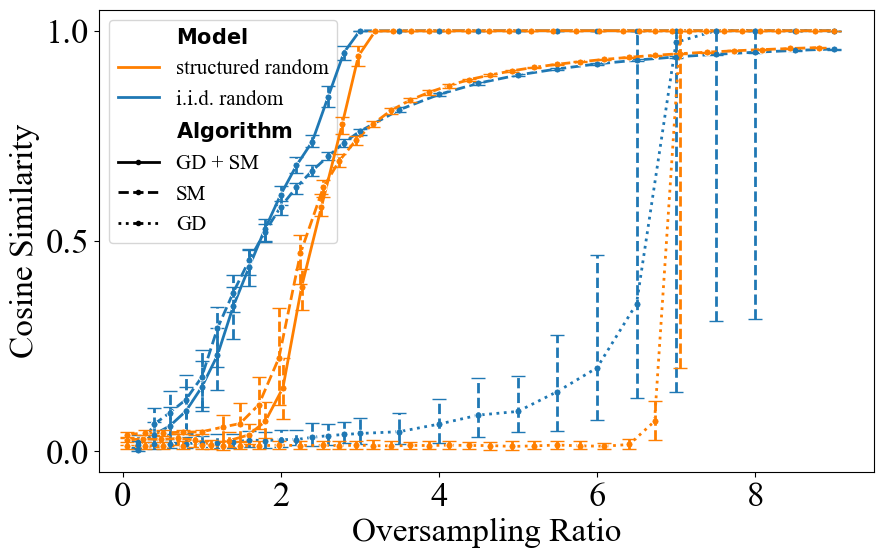

In [22]:
plot_error_bars([oversampling_ratios_random_gd_spec,
                 oversampling_ratios_random_spec,oversampling_ratios_random_gd_rand,oversampling_ratios_structured_gd_spec,oversampling_ratios_structured_spec,
                 oversampling_ratios_structured_gd_rand],
                [df_random_gd_spec,
                 df_random_spec,
                 df_random_gd_rand,
                 df_structured_gd_spec,
                 df_structured_spec,
                 df_structured_gd_rand],
                ['iid gd spec',
                 'iid spec',
                 'iid gd rand',
                 'structured gd spec',
                 'structured spec',
                 'structured gd rand'],
                figsize=(10,6),
                font="Times New Roman",
                fontsize=15,
                labelsize=24,
                xlim=(-0.3,9.5),
                yticks=[0.0,0.5,1.0],
                error_bar_linestyle="--",
                structured_color=sns.color_palette("Paired")[7],
                iid_color=sns.color_palette("Paired")[1],
                plot='reconstruction',
                ticksize=25,
                show=False,
                save_dir='paper/figures/accuracy.pdf')

# Weak Recovery Threshold

In [49]:
df_random_spec = pd.read_csv("/home/zhhu/workspaces/deepinv/experimental/paper/runs/20240807-154721/random/res_random_spectral_128size_100repeat_5000iter_0.10000000149011612-2.0.csv")
oversampling_ratios = df_random_spec["oversampling_ratio"]

spec


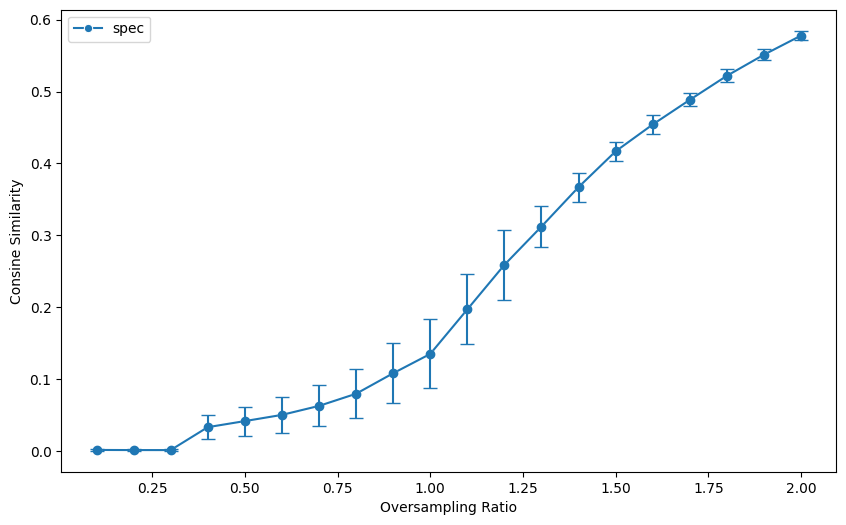

In [50]:
plot_error_bars([oversampling_ratios], [df_random_spec], ['spec'])

# Time Complexity

In [23]:
load_path = Path("/home/zhhu/workspaces/deepinv/experimental/paper/data/time")

In [24]:
df_random_cpu = pd.read_csv(load_path / "df_random_cpu.csv")
df_random_gpu = pd.read_csv(load_path / "df_random_gpu.csv")
df_structured_cpu = pd.read_csv(load_path / "df_structured_cpu.csv")
df_structured_gpu = pd.read_csv(load_path / "df_structured_gpu.csv")

In [25]:
df_random_gpu.iloc[0]["img_size_8"] = None
df_random_gpu

/tmp/ipykernel_3498706/1141376657.py:1: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df_random_gpu.iloc[0]["img_size_8"] = None


,img_size_8,img_size_16,img_size_32,img_size_64,img_size_96,img_size_128,img_size_160,img_size_192,img_size_224,img_size_240
0,NaN,0.000501,0.000638,0.000540,0.001046,0.003431,0.007872,0.016202,0.029026,0.031205
1,0.000252,0.000467,0.000466,0.000386,0.001200,0.003330,0.007773,0.016022,0.023464,0.031089
2,0.000179,0.000460,0.000462,0.000367,0.001196,0.003243,0.007803,0.016826,0.023490,0.031042
3,0.000170,0.000459,0.000453,0.000364,0.001208,0.003246,0.007780,0.016126,0.023477,0.031130
4,0.000168,0.000459,0.000451,0.000364,0.001168,0.003349,0.007809,0.015985,0.023582,0.031191
...,...,...,...,...,...,...,...,...,...,...
95,0.000164,0.000173,0.000174,0.000299,0.001241,0.003373,0.007748,0.016134,0.023584,0.031102
96,0.000164,0.000172,0.000170,0.000296,0.001233,0.003400,0.007826,0.016018,0.023588,0.030983
97,0.000164,0.000172,0.000168,0.000296,0.001230,0.003401,0.007770,0.016045,0.023482,0.031095
98,0.000165,0.000174,0.000168,0.000297,0.001246,0.003392,0.007826,0.015952,0.023474,0.031016


In [26]:
img_sizes_iid: list[int] = [8, 16, 32, 64, 96, 128, 160, 192, 224, 240]
img_sizes_structured: list[int] = [8, 16, 32, 64, 96, 128, 160, 192, 224, 240]
num_pixels_iid = [img_sizes_iid**2 for img_sizes_iid in img_sizes_iid]
num_pixels_structured = [img_sizes_structured**2 for img_sizes_structured in img_sizes_structured]

i.i.d. random (CPU)
(0.12156862745098039, 0.4666666666666667, 0.7058823529411765) i.i.d. random (CPU)
i.i.d. random (GPU)
(1.0, 0.4980392156862745, 0.054901960784313725) i.i.d. random (GPU)
structured random (CPU)
(0.17254901960784313, 0.6274509803921569, 0.17254901960784313) structured random (CPU)
structured random (GPU)
(0.8392156862745098, 0.15294117647058825, 0.1568627450980392) structured random (GPU)
Figure saved to paper/figures/time.pdf


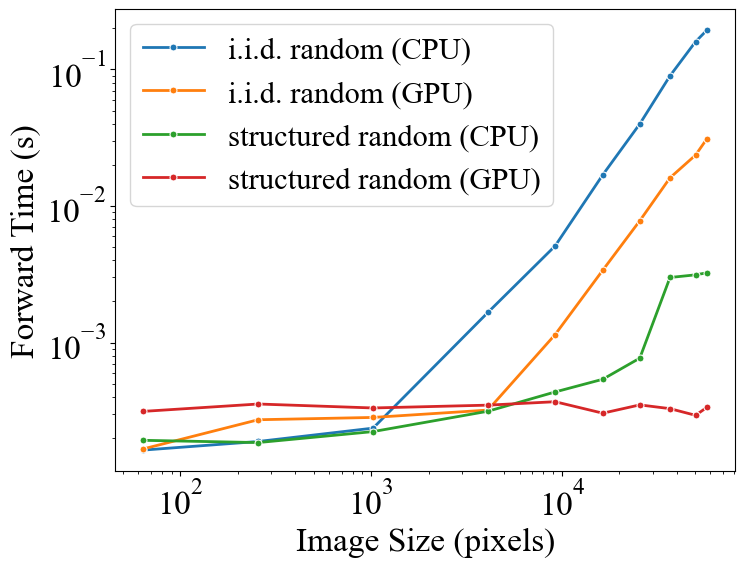

In [27]:
plot_error_bars([num_pixels_iid,
                 num_pixels_iid,
                 num_pixels_structured,
                 num_pixels_structured],
                [df_random_cpu,
                 df_random_gpu,
                 df_structured_cpu,
                 df_structured_gpu],
                ['i.i.d. random (CPU)','i.i.d. random (GPU)','structured random (CPU)','structured random (GPU)'],
                axis=0,
                figsize=(8,6),
                xscale='log',
                yscale='log',
                xlabel='Image Size (pixels)',
                ylabel='Forward Time (s)',
                legend_loc='upper left',
                plot='time',
                error_bar='std',
                save_dir='paper/figures/time.pdf',
                fontsize=22,
                labelsize=24,
                ticksize=24,
                bbox_inches = 'tight')

# Haar Matrix

In [19]:
df_haar = pd.read_csv("/home/zhhu/workspaces/deepinv/experimental/paper/runs/20240814-143200/res_random-haar_spectral_64size_100repeat_5000iter_1.0-4.0.csv")
df_random_spec = pd.read_csv("/home/zhhu/workspaces/deepinv/experimental/paper/runs/20240806-155124/random/res_random_spectral_100repeat_5000iter_0.10000000149011612-9.0.csv")
df_structured_spec = pd.read_csv("/home/zhhu/workspaces/deepinv/experimental/paper/runs/20240809-192806/structured/res_structured_2_spectral_100repeat_5000iter_0.0009765625-9.0.csv")

In [20]:
df_haar.head()

,Unnamed: 0,oversampling_ratio,step_size,repeat0,repeat1,repeat2,repeat3,repeat4,repeat5,repeat6,...,repeat90,repeat91,repeat92,repeat93,repeat94,repeat95,repeat96,repeat97,repeat98,repeat99
0,0,1.0,NaN,0.047303,0.049282,0.045656,0.043175,0.046687,0.047457,0.045254,...,0.051118,0.046019,0.047397,0.048223,0.050303,0.017573,0.042891,0.050161,0.044908,0.044706
1,1,1.2,NaN,0.046422,0.053954,0.035129,0.066281,0.049816,0.058801,0.050490,...,0.076083,0.051632,0.053922,0.072903,0.078531,0.045516,0.062775,0.047310,0.069483,0.043679
2,2,1.4,NaN,0.094311,0.080527,0.066467,0.065786,0.088027,0.037578,0.024276,...,0.054283,0.030492,0.053757,0.025851,0.049885,0.060053,0.081499,0.058904,0.103744,0.110128
3,3,1.6,NaN,0.088224,0.063986,0.099422,0.086343,0.120125,0.016635,0.122851,...,0.103328,0.062821,0.136350,0.094636,0.112892,0.017891,0.048939,0.079879,0.152214,0.093944
4,4,1.8,NaN,0.075326,0.146212,0.138467,0.084282,0.110602,0.075195,0.188445,...,0.181928,0.181581,0.102897,0.071132,0.171630,0.164191,0.156077,0.030949,0.027696,0.089007


In [21]:
for df in [df_random_spec,df_structured_spec]:
    rows_to_drop = []
    for index, row in df.iterrows():
        if row['oversampling_ratio'] < 1.0 or row['oversampling_ratio'] > 4.0:
            rows_to_drop.append(index)

    df.drop(rows_to_drop, inplace=True)

In [22]:
overesampling_ratios_haar = df_haar["oversampling_ratio"]
oversampling_ratios_random_spec = df_random_spec["oversampling_ratio"]
oversampling_ratios_structured_spec = df_structured_spec["oversampling_ratio"]

haar
(0.12156862745098039, 0.4666666666666667, 0.7058823529411765) haar
iid
(1.0, 0.4980392156862745, 0.054901960784313725) iid
structured
(0.17254901960784313, 0.6274509803921569, 0.17254901960784313) structured


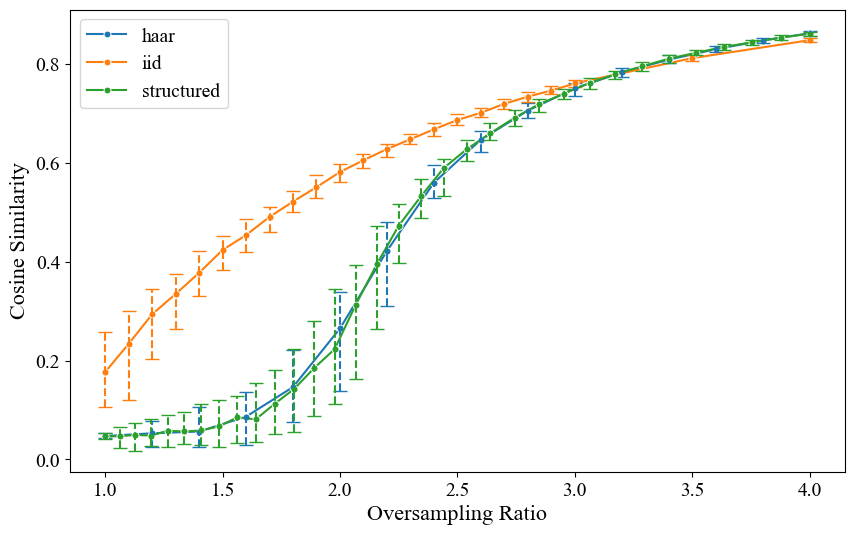

In [23]:
plot_error_bars([overesampling_ratios_haar,oversampling_ratios_random_spec,oversampling_ratios_structured_spec], [df_haar,df_random_spec,df_structured_spec], ['haar','iid','structured'])